## 2. Sensors / Signal Acquisition

Scenario: Multiple experts have been asked, how they would choose the parameters / what they believe are the ranges of the parameters:

#### Placement of Sensors
- $n_\mathrm{sen} = $ Number of sensors max. 12 channels
- $\operatorname{loc}_\mathrm{sen} = 0.2:[\mathrm{lumped}];0.8:[\mathrm{distributed}]$ Placement of sensors (evenly distributed, every five meters, distance between sensors min. 20 meters; both directions simultaneously!)

#### Type of Sensors
- $q_\mathrm{sen} = 0.8[\mathrm{a}];0.2[\mathrm{v}]$ Measurement quantity (acceleration, velocity)
- $\operatorname{SNR}_\mathrm{sen} = $ Sensor noise variance (pre-sampling, white noise)<br>
**TODO: The datasheets of different sensors should be examined, to obtain reasonable values for these parameters. PCB 393A01, PCB 393B31, Gyralp GMC 40, Lennarts**

#### Signal acqusition system
- Broadband Resolution
    - $q = $ Quantization range. <br>
    **TODO: Usually set on the basis of preliminary measurements. Provide an example signal to given knowledge, and then range x 2 ... 10 and round to a voltage level**
    - $b = [0.05:12, 0.5:16, 0.3:24, 0.05:32]$ Number of quantization bits (**TODO: allow discrete ranges? e.g. 12,16,24,32)**
- Aliasing Filter (FIR: Windowed Sinc)
    - $f_c = $ Filter 3 dB cutoff frequency 2...2.5
    - $w_\mathrm{type}[m]$ Window type  **TODO: Which window types to include (rectangular, hanning, hamming, etc.)?**
    - $M = $ Window length
- $f_s = $ Sample rate $f_s = \frac{1}{\Delta t}$
- $N = $ Number of Timesteps / Measurement Duration $T = N \Delta t$
- $\operatorname{SNR}_\mathrm{acq} = $ Acquisition system noise variance (post-sampling, white noise) <br>
  **TODO: Where to get reasonable values? from Datasheets**
- **TODO: model the built-in highpass filter**

#### Outputs
- Total SNR
- Effective quantization bits [Channel average] (Considering range, bits and actual vibration level)
- **TODO: Estimated SNR**

In [43]:
%matplotlib widget
%load_ext autoreload
%autoreload 2
%load_ext snakeviz
# dont forget to forward ports: ssh -L 8080:127.0.0.1:8080 sima9999@makalu47.rz.tu-ilmenau.de

import sys
import os
sys.path.append("/home/sima9999/code/")
from pathlib import Path

import matplotlib
import matplotlib.pyplot as plt
import numpy as np

from model.mechanical import Mechanical, MechanicalDummy
from model.acquisition import Acquire

%aimport -sys -logging -matplotlib -matplotlib.pyplot -numpy -pandas - scipy.stats -scipy.stats.qmc

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The snakeviz extension is already loaded. To reload it, use:
  %reload_ext snakeviz


## Parameters

In [44]:
'''
Continue:

estimate incompleteness on any output e.g. RMS_a(TMD_y)


Read, understand and connect model.acquisition.Acquire class with model.mechanical.Mechanical
implement helper to generate channel definitions
implement method apply_sensor
Get frequency responses of sensors
get SNR of sensors
'''

'\nContinue:\n\nestimate incompleteness on any output e.g. RMS_a(TMD_y)\n\n\nRead, understand and connect model.acquisition.Acquire class with model.mechanical.Mechanical\nimplement helper to generate channel definitions\nimplement method apply_sensor\nGet frequency responses of sensors\nget SNR of sensors\n'

## Structural Model generation

INFO:model.mechanical:Now loading previous results from  /usr/scratch4/sima9999/work/modal_uq/uq_oma_a/samples/mechanical.npz


Text(0, 0.5, 'Modal damping ratio [%]')

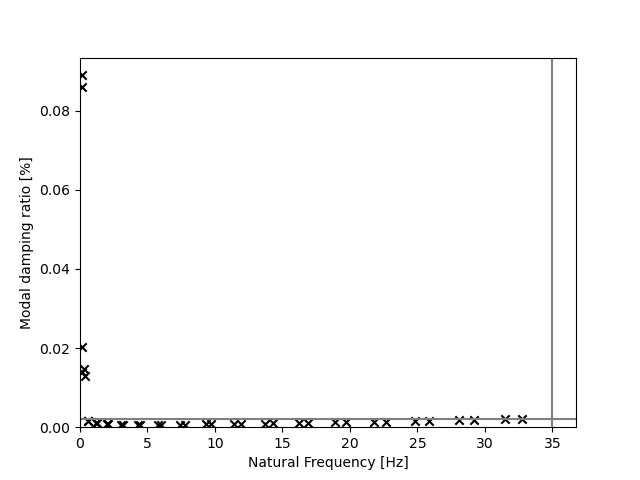

In [49]:
from model.mechanical import Mechanical, MechanicalDummy

if os.path.split(result_dir)[-1] != 'samples':
    result_dir=result_dir / 'samples'

jid = 'd3f294e6_e3f6077f'

zeta = 0.002 # normal damping
# zeta = 0.0005 # light damping
# zeta = 0.005 # heavy damping
Iy = 0.01196
Iz = 0.01304
alpha = 45

fs_m = 70
duration = 2**19/fs_m

v_b = 25.0
skip_existing = True

if not isinstance(result_dir, Path):
    result_dir = Path(result_dir)

if not isinstance(working_dir, Path):
    working_dir = Path(working_dir)

# Set up directories
if '_' in jid:
    id_ale, id_epi = jid.split('_')
    this_result_dir = result_dir / id_ale
    if not os.path.exists(this_result_dir):
        os.makedirs(this_result_dir)

    this_result_dir = this_result_dir / id_epi
    if not os.path.exists(this_result_dir):
        os.makedirs(this_result_dir)
else:
    this_result_dir = result_dir / jid
    if not os.path.exists(this_result_dir):
        os.makedirs(this_result_dir)


seed = int.from_bytes(bytes(jid, 'utf-8'), 'big')
        
# assemble structural parameters
struct_parms = {
        'L'         : 200,

        'E'         : 2.1e11,
        'A'         : 0.03287,

        'x_knl'     : 160,

        'm_tmd'     : 800,
        'ky_tmd'    : 1025.48,
        'kz_tmd'    : 1025.48,
        'dy_tmd'    : 200,
        'dz_tmd'    : 200,
        'x_tmd'     : 200,
        }

# Cross-section
Iyz = 0
# rotate cross section about angle alpha
alpha = alpha * 2 * np.pi / 360
struct_parms['Iy'] = 0.5 * (Iy + Iz) + 0.5 * (Iy - Iz) * np.cos(2 * alpha) + Iyz * np.sin(2 * alpha)
struct_parms['Iz'] = 0.5 * (Iy + Iz) - 0.5 * (Iy - Iz) * np.cos(2 * alpha) - Iyz * np.sin(2 * alpha)
struct_parms['Iyz'] = -0.5 * (Iy - Iz) * np.sin(2 * alpha) + Iyz * np.cos(2 * alpha)

# equivalent spring stiffness of guy cables
A_wire = 0.00075
rho = 7850
N_wire = 60000
Aeq = A_wire/(1 + (A_wire * rho * 9.819 * 70 / N_wire)**2 * struct_parms['E'] * A_wire / 12 / N_wire)
keq = (struct_parms['E'] * Aeq * (70**2 / (70**2 + 160**2)) + N_wire) / np.sqrt(70**2 + 160**2)
struct_parms['kz_nl'] = 1.7 * keq
struct_parms['ky_nl'] = 2 * keq

# additional mass into mass density
add_mass = 60
struct_parms['rho'] = rho + add_mass / struct_parms['A']

# model parameters
num_nodes = 201
num_modes = 38 # ensure max(f) is below nyquist frequency to avoid wrap-around in the frf

# load or build structural model
mech = None
if skip_existing and os.path.exists(result_dir / f'mechanical.npz'):
    try:
        mech = MechanicalDummy.load(fpath=result_dir / f'mechanical.npz')
        assert mech.struct_parms['Iy'] == struct_parms['Iy']
        assert mech.struct_parms['Iz'] == struct_parms['Iz']
        assert mech.struct_parms['Iyz'] == struct_parms['Iyz']
        assert mech.damping == zeta
        assert mech.omegas is not None
        assert mech.frf is not None
    except Exception as e:
        mech = None
        raise e

if mech is None:
    global ansys
    if 'ansys' not in globals():
        ansys = Mechanical.start_ansys(working_dir=working_dir, jid=jid)
    mech = Mechanical(ansys=ansys, jobname=jid, wdir=working_dir)
    mech.build_conti(struct_parms, 
                     Ldiv=num_nodes, damping=zeta, 
                     num_modes=num_modes)

f,d,phi = mech.modal()

plt.figure()
plt.axhline(zeta, color='grey')
plt.axvline(fs_m/2, color='grey')
plt.scatter(f,d,  marker='x', color='k')
plt.xlim(xmin=0)
plt.ylim(ymin=0)
plt.xlabel('Natural Frequency [Hz]')
plt.ylabel('Modal damping ratio [%]')
# plt.yscale('log')

## Transient Solution

In [50]:
%%time
if os.path.exists(this_result_dir / 'response.npz') and skip_existing:
    arr = np.load(this_result_dir / 'response.npz')
    t_vals = arr['t_vals']
    d_freq_time = arr['d_freq_time']
    v_freq_time = arr['v_freq_time']
    a_freq_time = arr['a_freq_time']
else:
    t_vals, response = mech.transient_ifrf(Fu_time, Fv_time,
                                           mech.nodes_coordinates[0:-2,0],
                                           inp_dt = 1 / fs_m)

    [d_freq_time, v_freq_time, a_freq_time] = response       
    # FRF was not pre-computed: save, clear and exit
    if isinstance(mech, Mechanical):
        print('save')
        mech.save(os.path.join(result_dir, 'mechanical.npz'))
        ansys.finish()
        ansys.cwd('/dev/shm/womo1998/')
        ansys.clear()
    
    np.savez(this_result_dir / 'response.npz', 
             t_vals=t_vals, 
             d_freq_time=d_freq_time, 
             v_freq_time=v_freq_time, 
             a_freq_time=a_freq_time)
    print(this_result_dir / 'response.npz')

# zeros = np.zeros((N_m, 1))
# t, [d_time, v_time, a_time] = mech.transient(fy=np.hstack((Fu_time, zeros, zeros)), 
#                                              fz=np.hstack((Fv_time, zeros, zeros)), 
#                                              deltat=1 / fs_m, timesteps=N_m)
# # remove DOF x
# d_time = d_time[:,:,1:]
# v_time = v_time[:,:,1:]
# a_time = a_time[:,:,1:]

CPU times: user 5.75 s, sys: 3.16 s, total: 8.92 s
Wall time: 11.3 s


(<Figure size 640x480 with 3 Axes>,
 <Figure size 640x480 with 3 Axes>,
 <Figure size 640x480 with 3 Axes>)

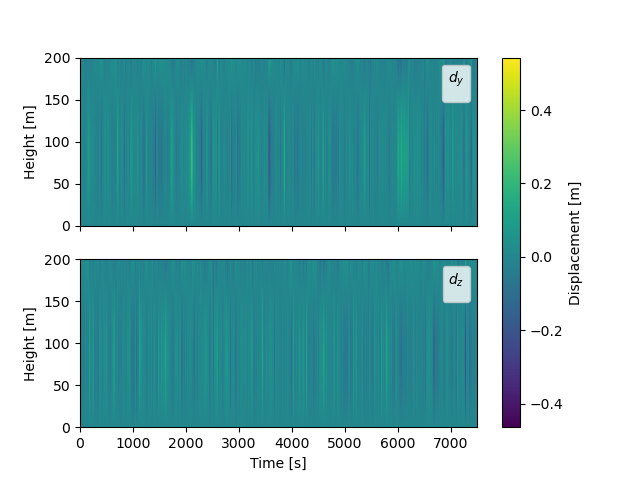

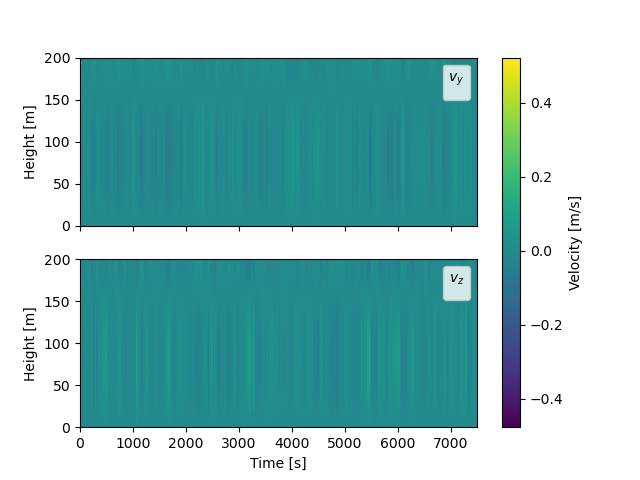

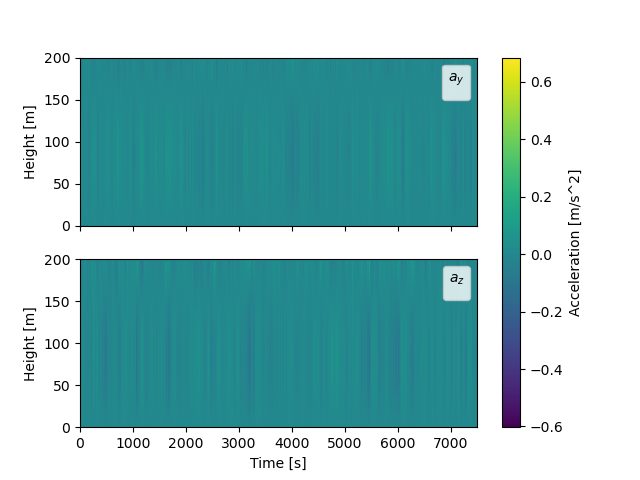

In [51]:
plot_response_field(d_freq_time, v_freq_time, a_freq_time, duration, height=200)

In [227]:
mech.t_vals_amb = t_vals
mech.resp_hist_amb = [d_freq_time, v_freq_time, a_freq_time]
mech.deltat = t_vals[1] - t_vals[0]
mech.timesteps = t_vals.shape[0]
mech.state[2] = True

### Placement of sensors

Uncertainty is about:
Where will it be possible to place sensors (epistemic, reducible)?
How can the modal characteristics be best captured in a given frequency range?

In reality:
A numerical model is set up based on uncertain model parameters and solved. A 
frequency range of interest is selected. Commonly the the modes up to fifth order
are of interest (sampling is later done at a much higher sample rate, though). 
Then, by assessing the mode shapes, the location of sensors is decided upon.
It won't be possible to place the sensors at arbitrary locations and also some
practical issues, such as cable lengths, etc. come into play. 

Single-setup or multi-setup measurements are possible. In multi-setup
measurements, usually a reference sensor is placed at a location, where all
modes of interest exhibit sufficient vibration levels. The remaining sensors can
then be distributed evenly or lumped in multiple setups until all locations of
interest are covered.
In single-setup measurements, it is tried to place all available sensors such
that all modes of interest exhibit as large vibration levels as possible, i.e.
avoid nodes of mode shapes [brehm2011vibration]. 
This method requires the mode shapes and natural frequencies to be known beforehand
To stay with the notion of the study, these are epistemically uncertain. We would 
have to model this uncertainty, which would deviate too far from the original goals of the study.
Another option would be to just distribute them evenly.

In this example,
we assume, sensors can be placed every five meters and on the TMD itself.
In either case, assume a sensor is placed at the top node. The TMD node may then
be covered by the specified placement method.
divide remaining range, not on bottom node
lumped or evenly distributed
randomly choose one of the possible setups

In [216]:
def sensor_position(num_sensors, num_nodes, method):
    assert method in ['lumped','distributed']

    all_positions = np.arange(5, num_nodes, 5)
    num_positions = all_positions.shape[0]
    num_clusters = int(np.floor(num_positions/num_sensors))

    if method == 'distributed': 
        clusters = np.reshape(all_positions[:num_sensors*(num_clusters)], (num_sensors, num_clusters)).T
        last_setup = all_positions[- (num_sensors - 1) * (num_clusters) - 1::num_clusters]
    elif method == 'lumped': 
        clusters = np.reshape(all_positions[:num_sensors*(num_clusters)], (num_clusters, num_sensors))
        last_setup = np.reshape(all_positions[-num_sensors:], (1, num_sensors))

    clusters = np.vstack((clusters, last_setup))

    return clusters

In [229]:
# list of (node, dof, quant)
n_channels = 14
quant = 'a'
i_cluster=1

sensor_nodes = sensor_position(n_channels//2, mech.num_nodes, 'distributed')[i_cluster,:]
channel_defs = []
for node in sensor_nodes:
    for dof in ['ux','uy']:
        channel_defs.append((node, dof, quant))


In [230]:
#TODO: Generate Channel Defs from sensor_position and then continue implementation

acqui = Acquire.init_from_mech(mech, channel_defs)

INFO:model.acquisition:Initializing Acquire object from a Mechanical object


### Spectral Sensitivity

The spectral sensitivity consist of three parts:
- The high frequency response, determined by the resonant frequency of the sensor -> given as an inequality
- The low frequency response, due by the high-pass filtering of the internal electronics (RC-Circuit), determined by the Discharge Time Constant
- The sensivitity of the sensor, i.e. the voltage to acceleration relation -> given as a range or inequality

The resulting 2-DOF FRF is additionally specified in terms of the frequency ranges for a sensitivity deviation of $\pm$ 5 % and $\pm10$ %, respectively. The theoretical and tabulated FRFs match only approximately.

In [568]:
fn = 50000
frequencies = np.fft.rfftfreq(acqui.num_timesteps, acqui.deltat)
zeta_sensor=0.01
ind = np.argmin(np.abs((frequencies - 5000)))
display(frequencies[ind])

time_constant = 1# Entladezeitkonstante 1...2.5 s = R*C
fc=1/2/np.pi/time_constant
display(fc)

35.0

0.15915494309189535

In [569]:
D1 = 1 + 2 * 1j * zeta_sensor * frequencies / fn
D2 = 1 - (frequencies / fn)**2 + 2 * 1j * zeta_sensor * frequencies / fn
Hf = D1 / D2
Hc = time_constant * 2 * np.pi * 1j * frequencies / (1 + time_constant * 2 * np.pi * 1j * frequencies)

H = Hf * Hc

/tmp/ipykernel_20861/1037821883.py:2: RuntimeWarning: divide by zero encountered in log10
  plt.plot(frequencies, 10*np.log10(np.abs(H)))


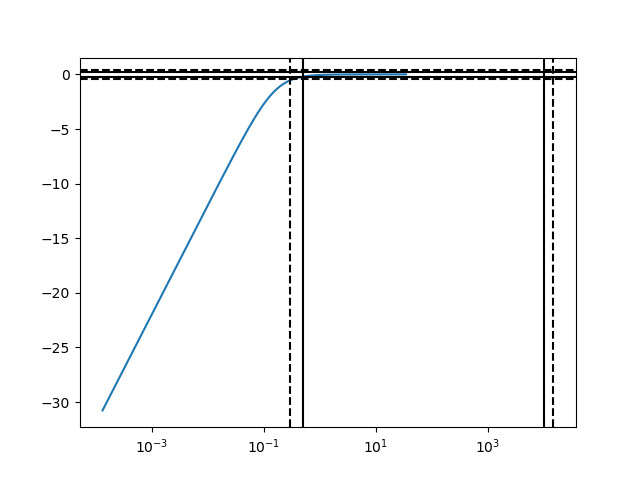

In [570]:
plt.figure()
plt.plot(frequencies, 10*np.log10(np.abs(H)))
plt.axvline(0.5,color='k',)
plt.axvline(10000,color='k',)
plt.axhline(10*np.log10(1.05),color='k',)
plt.axhline(10*np.log10(0.95),color='k',)
plt.axvline(0.3, color='k',ls='dashed')
plt.axvline(15000, color='k',ls='dashed')
plt.axhline(10*np.log10(1.1), color='k',ls='dashed')
plt.axhline(10*np.log10(0.9), color='k',ls='dashed')
plt.xscale('log')

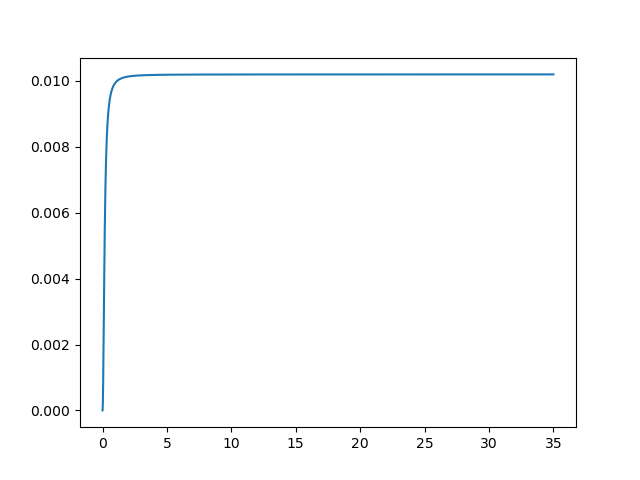

In [571]:
plt.figure()
plt.plot(frequencies, H*10.2/1000)

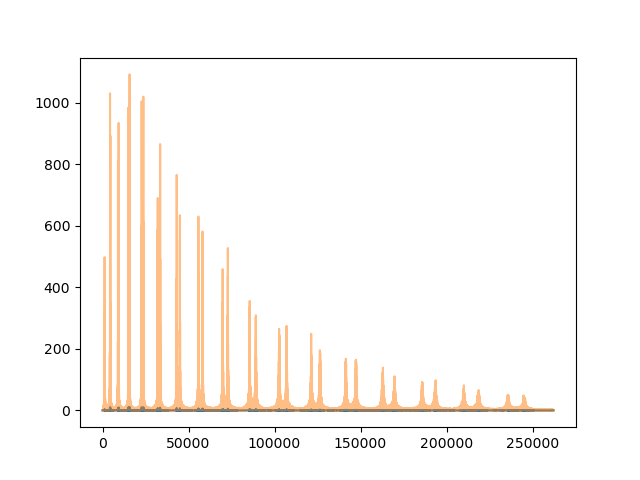

In [576]:
plt.figure()
plt.plot(np.abs(np.fft.rfft(acqui.signal[0,:])*H*10.2/1000))
plt.plot(np.abs(np.fft.rfft(acqui.signal[0,:])), alpha=0.5)

In [559]:
'''
Ressources:
https://en.wikipedia.org/wiki/RC_circuit
https://www.pcb.com/resources/technical-information/signal-conditioning-basics#collapse13
https://www.pcbpiezotronics.de/produkte/datenblatt?h=PCB&m=352C33&cHash=1bd70739507f7a96620a16632ca50a2c
/home/womo1998/Downloads/Jon%20S.%20Wilson%20-%20Sensor%20Technology%20Handbook-Newnes%20(2005).pdf
https://www.edn.com/a-guide-to-accelerometer-specifications/
https://www.f3lix-tutorial.com/
https://kistler.cdn.celum.cloud/SAPCommerce_Download_original/900-380e.pdf
https://dewesoft.com/blog/noise-floor-analysis

Continue:
- Add Kistler Sensors
    - https://www.kistler.com/DE/en/cp/low-temperature-iepe-accelerometers-8712b/P0000551
    - https://www.kistler.com/DE/en/cp/triaxial-iepe-accelerometers-8762a/P0000558
- Write about:
    - Theory/ Assumptions/  Charge amplified accelerometers, principle (resonance), amplifiers (highpass RC filter, Settling time, discharge time, etc.)
    - Sensitivity (Deviation, Temperature Deviation, Strain Deviation, Linearity)
    - Frequency response (Frequency Ranges)
    - Noise (Resistor, Transistor) Spectral, Broadband, RMS, peak, integration
- Inverse FRF model with incomplete Data
- Make sensor database available programmatically
- Write Function apply sensor
- Write Save/Load function for Acquire

- Do some research into digitizers?

cls(t_vals, signal, channel_defs, jobname)

self.num_modes = None
self.snr = [np.mean(signal**2, axis=1), np.zeros((self.num_channels,))]
self.is_sampled = False

Sampling

    Changed/Added Variables/Outputs:
    
    self.modal_frequencies
    self.re_shape[-1]
    self.num_timesteps
    self.deltat
    self.t_vals
    self.signal
    # self.snr
    self.   quantization noise power
    self.   aliasing noise power
    
    Inputs
    
    fs, numtaps, cutoff -> from sample_helper
        f_max -> epistemic
        nyq_rat -> epistemic
        numtaps_fact -> deterministic
    bits, -> epistemic
    meas_range -> from estimate_meas_range
        sample_dur -> epistemic
        margin -> epistemic
        seed -> deterministic
    duration -> epistemic
    
    
Noising

    self.   noise power
    self.signal
    self.snr
    
    snr_db


'''

'\n\nCONTINUE:\nhttps://en.wikipedia.org/wiki/RC_circuit\nhttps://www.pcb.com/resources/technical-information/signal-conditioning-basics#collapse13\nhttps://www.pcbpiezotronics.de/produkte/datenblatt?h=PCB&m=352C33&cHash=1bd70739507f7a96620a16632ca50a2c\nfile:///home/womo1998/Downloads/Jon%20S.%20Wilson%20-%20Sensor%20Technology%20Handbook-Newnes%20(2005).pdf\n\ncls(t_vals, signal, channel_defs, jobname)\n\nself.num_modes = None\nself.snr = [np.mean(signal**2, axis=1), np.zeros((self.num_channels,))]\nself.is_sampled = False\n\nSampling\n\n    Changed/Added Variables/Outputs:\n    \n    self.modal_frequencies\n    self.re_shape[-1]\n    self.num_timesteps\n    self.deltat\n    self.t_vals\n    self.signal\n    # self.snr\n    self.   quantization noise power\n    self.   aliasing noise power\n    \n    Inputs\n    \n    fs, numtaps, cutoff -> from sample_helper\n        f_max -> epistemic\n        nyq_rat -> epistemic\n        numtaps_fact -> deterministic\n    bits, -> epistemic\n    

### Spectral Noise

Threshold
• The smallest change in acceleration that will result in a
measureable change in sensor output. (ISA RP37.1)
• Often used interchangeably with Residual Noise,
Broadband Resolution and Noise Floor
• Measured in many different ways and may lead to
confusion when using or comparing accelerometers
– broadband - g rms, g pk, g pk-pk
– frequency limited broadband (1 Hz to 10 kHz) - g rms
– spectral noise floor - g/√Hz


Sometimes one encounters an amplitude spectral density (ASD), which is the square root of the PSD; the ASD of a voltage signal has units of V Hz−1/2

'Noise floor RMS generated: 1.101e-04 and specified: 1.000e-04 and integrated: 1.479e-04, ratio: 1.1010902535779634, 1.4794693743466372,  0.744246736478899'

'Noise floor RMS generated: 9.553e-05 and specified: 1.000e-04 and integrated: 1.021e-04, ratio: 0.9552703000842369, 1.021022798744257,  0.9356013413795575'

'Noise floor RMS generated: 9.826e-05 and specified: 1.000e-04 and integrated: 9.867e-05, ratio: 0.982580657441395, 0.9867410940397013,  0.9957836593373511'

'Noise floor RMS generated: 9.823e-05 and specified: 1.000e-04 and integrated: 9.831e-05, ratio: 0.9823041892695441, 0.9830576686373321,  0.9992335349269668'

'Noise floor RMS generated: 9.826e-05 and specified: 1.000e-04 and integrated: 9.827e-05, ratio: 0.9826282011000725, 0.9826902888492725,  0.9999368185989987'

'Noise floor RMS generated: 1.419e-06 and specified: 9.000e-06 and integrated: 4.036e-06, ratio: 0.15770081452026513, 0.4484298675782644,  0.351673307070122'

'Noise floor RMS generated: 2.121e-06 and specified: 9.000e-06 and integrated: 2.426e-06, ratio: 0.23569608119407276, 0.26957731143481023,  0.8743172039946296'

'Noise floor RMS generated: 2.267e-06 and specified: 9.000e-06 and integrated: 2.295e-06, ratio: 0.25191690959193297, 0.2550325790712743,  0.9877832491413947'

'Noise floor RMS generated: 2.278e-06 and specified: 9.000e-06 and integrated: 2.281e-06, ratio: 0.2531412952781766, 0.25345035575146485,  0.9987805877313846'

'Noise floor RMS generated: 2.279e-06 and specified: 9.000e-06 and integrated: 2.280e-06, ratio: 0.25326111817219127, 0.2532923952568891,  0.9998765178691363'

'Noise floor RMS generated: 1.740e-03 and specified: 1.500e-03 and integrated: 2.798e-03, ratio: 1.1600547404830153, 1.8651511661063784,  0.6219628529652657'

'Noise floor RMS generated: 1.843e-03 and specified: 1.500e-03 and integrated: 1.953e-03, ratio: 1.2289610455930615, 1.3018312523948463,  0.9440248444890741'

'Noise floor RMS generated: 1.880e-03 and specified: 1.500e-03 and integrated: 1.888e-03, ratio: 1.2536235717685327, 1.258741537977695,  0.9959340610802557'

'Noise floor RMS generated: 1.880e-03 and specified: 1.500e-03 and integrated: 1.881e-03, ratio: 1.2534598026949857, 1.2541190815047447,  0.9994743092426533'

'Noise floor RMS generated: 1.880e-03 and specified: 1.500e-03 and integrated: 1.880e-03, ratio: 1.2535553910551063, 1.253657618134211,  0.999918456939418'

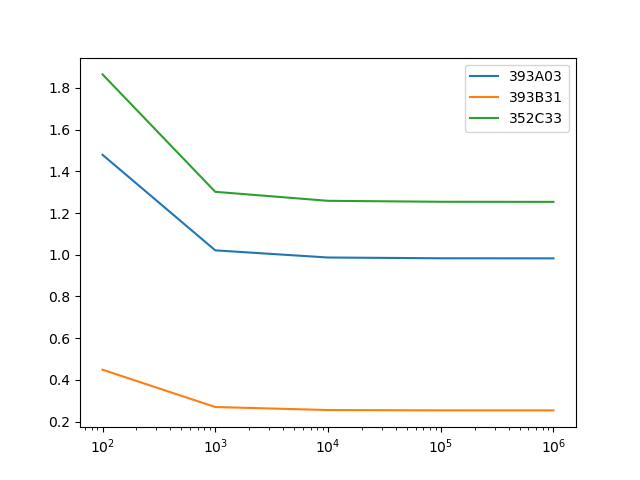

In [1245]:
plt.figure()
N = acqui.num_timesteps
dt_facs= [0.001,0.01,0.1,1,10,100,1000]
Ns = [100,1000,10000,100000,1000000]

for sensor in ['393A03','393B31','352C33']:
    ratios = []
    dt_fac=1
    for N in Ns:
        dt = acqui.deltat*dt_fac
        dt=1/2000
        # sensor = '393A03'
        # sensor = '393B31'
        # sensor = '352C33'
        spectral_freq = np.array([1,10,100,1000])/dt_fac
        spectral_noise_table = {
            '393A03': [20e-6, 4e-6, 2e-6, 1e-6],
            '393B31': [0.6e-6, 0.1e-6, 0.04e-6, 0],
            '352C33': [380e-6, 110e-6, 33e-6, 14e-6]
            }
        broadband_res = {"393A03": 0.0001, "393B31":  0.000009, "352C33": 0.0015}[sensor]

        freq = np.fft.rfftfreq(N, dt)
        
        delta_f = freq[1]-freq[0]
        phase = np.random.uniform (-np.pi, np.pi, N//2+1)
        # Amplitude/RMS spectrum given, must not be square rooted for IFFT
        psd = np.interp(freq, spectral_freq, spectral_noise_table[sensor]) * np.exp(1j * phase)
        # Account for (µm/sec2)/√Hz unit
        psd /= np.sqrt(dt)
        # Apply ortho norm here, because we input an unnormalized amplitude spectrum (normally PSD * N and norm backward applies 1/N)
        spectral_noise = np.fft.irfft(psd, norm='ortho')
        
        RMS_noise = np.sqrt(np.average(spectral_noise**2))
        integr_noise = np.sqrt(np.sum(np.abs(psd)**2)/N*2) # delta_f=1/dt/N: integration, 2: one-sided
        ratios.append(integr_noise/broadband_res)
        display(f'Noise floor RMS generated: {RMS_noise:1.3e} and specified: { broadband_res:1.3e} and integrated: {integr_noise:1.3e}, ratio: {RMS_noise/broadband_res}, {integr_noise/broadband_res},  {RMS_noise/integr_noise}')
    # plt.plot(dt_facs, ratios)
    plt.plot(Ns, ratios, label=sensor)
    # plt.yscale('log')
    plt.xscale('log')
plt.legend()

In [1231]:
display(f'Signal energy in time domain: {np.sum(spectral_noise**2):1.3e}, in frequency domain {2*np.sum(np.abs(psd)**2)/N:1.3e}')
delta_f = freq[1]-freq[0]
display(f'Noise floor RMS generated: {RMS_noise:1.3e} and specified: { broadband_res:1.3e} and integrated: {np.sum(np.abs(psd)*delta_f):1.3e}, ratio: {RMS_noise/broadband_res}')

'Signal energy in time domain: 3.536e-12, in frequency domain 3.536e-12'

'Noise floor RMS generated: 8.409e-08 and specified: 1.500e-03 and integrated: 1.349e-03, ratio: 5.6062976392985574e-05'

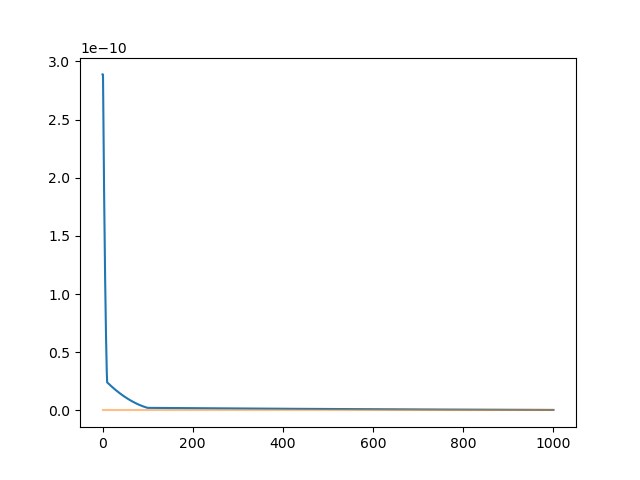

In [1232]:
plt.figure()
plt.plot(freq, np.abs(psd)**2)
plt.plot(*scipy.signal.csd(spectral_noise, spectral_noise, 1/dt, nperseg=1024, scaling='density'), alpha=0.5)

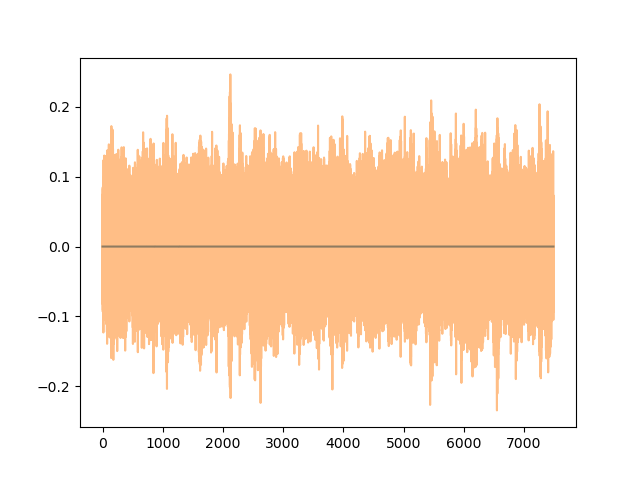

In [964]:
plt.figure()
plt.plot(np.linspace(0, N*dt,N), spectral_noise)
plt.plot(acqui.t_vals, acqui.signal[0,:], alpha=0.5)

In [916]:
'Noise floor RMS generated: 4.728e-05 and specified: 1.000e-04' # 393A03   0.4728
'Noise floor RMS generated: 1.364e-06 and specified: 9.000e-06' # 393B31   0.15155
'Noise floor RMS generated: 9.934e-04 and specified: 1.500e-03' # 352C33   0.66

'Noise floor RMS generated: 9.934e-04 and specified: 1.500e-03'

### Database

A list of currently available analog seismic accelerometers was compiled. Those are assumed suitable for ambient vibration testing on civil structures with the purpose of conducting Operational Modal Analysis. Other sensors, such as Digital/MEMS accelerometers, accelerometers with a sensitivity below 0.1V/g, seismometers (measuring velocities), laser vibrometers etc. are made for different purposes and are not included here. Temperature is assumed constant at specification temperature, no temperature transients, sensitivity deviations, etc. are considered. Assuming proper mounting, thus no changes to sensitivity due to base strain. Assuming properly calibrated sensors, with known sensitivities, (no sensitivity deviations).

The characteristics of the sensors are specified differently by the manufacturers: 
- in g or m/sec^2, 
- in different frequency bands
- in decibel or percent

